# AdaBoost Technique.

Before we start learning about how Adaboost works, here is an overview of what it is.

Adaboost stands for <b>Adaptive Boosting</b>. It is an ensemble technique which helps combine multiple weak classifiers and use an optimally weighed majority sum for to combine and build a stronger classifier. So it is not a new classification technique on its own, rather it builds on top of other techniques. 

<b>Note:</b> A weak classifier should still perform better than a random guess.

Adaboost performs two steps:

1. It iteratively helps you select the training set for each new classifier you build, based on the accuracy of the previous classifier. Misclassified item are assigned higher weight to ensure that wrongly predicted samples are highly represented in training subset of the next weak classifier with a higher probability.

2. It determines the weight that must be assigned to the output of each classifier for the majority sum. The weight of the classifier is dependent on its accuracy. Assuing binary classification, a classifier with 50% accuracy (random guess) is not assigned any weight. Higher the accuracy, higher the assigned weight.

### General intuition of how AdaBoost works:
    
1. As stated earlier, the basic principle behind AdaBoost is to use a sequence of weak learners, and tweaking the data at every iteration based on the output of the classifier at that step. 

2. If we have N training samples, then the data modification at each iteration assigns weights w_1, w_2, ..., w_N to each of these samples. For example, in the first step, since we are only working with the original data, we assign equal weight to every sample i.e. w_i = 1/N.

3. For every i-th iteration, the weights for each sample are modified and the learning algorithm is applied to the newly reweighted data in the next iteration. 

4. At the i-th iteration, the samples that were incorrectly predicted (remember: weak classifier), are assigned a higher weight, and the correctly predicted samples are assigned a lower weight. Intuitively, this allows the next iteration to focus more on the incorrectly predicted samples. We repeat the process until we have lowered the error rate to a desired value. Here, the error rate is based on the final "boosted" classifer based on the sequence of weak classifiers processed so far.

5. In the end, the predictions from all the classifiers are combined using a weighted majority sum (typically) to get a "boosted" output. While, we have discussed weighted majority sum as a way to combine the output, you may also leverage other techniques such as weighted majority vote. 

### AdaBoost code w/ example

We will now implement AdaBoost and walkthrough an example of binary classification. 

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

The sklearn module is a really powerful machine learning library for Python. It also provides us with a bunch of datasets that we can use to test our code. We will use the breast cancer dataset today. We won't describe the whole dataset here, but in summary it contains features such as radius of the cell nucleus, perimeter, area etc. You can read more about the dataset here: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

In [12]:
dataset = load_breast_cancer()  #loading one of the pre-available sklean datasets
data = dataset.data
labels = dataset.target
print(data.shape) # This will output (569, 30). Our data is a matrix of N x dim, where N is the number of samples and dim is the number of features
print(dataset.target_names) # you can check how your data looks like this. These are the two classes
print(dataset.feature_names) #the 30 features for the dataset in order

(569, 30)
['malignant' 'benign']
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


We will initialize some key variables we need. We specify the number of iterations we want the adaboost to perform. We 
also specify the number of dimensions in our data. If you carefully examine the dataset we loaded above, we have 30 features, therefore our dimensionality is 30. 

In [13]:
N = data.shape[0]
dim = data.shape[1]
no_of_iterations = 50 

labels = labels * 1.0 #converting to float

if len(labels) < N:
    print("error! you are missing labels")
elif len(labels) > N:
    print("error! you have extra labels!")


zero_vals = np.where(labels == 0)

for i in zero_vals:
    labels[i] = -1  #reassigning all 0s to -1
    

For purposes of this implementation, the error rate is simply a weighted sum of the errors. If a sample is correctly classified, we assign a weight of 0, 1 otherwise. We now define a function that calculates the error rate for a weak classifier. 

In [14]:
def generic_clf_error(data, labels, weights, dim, thresh, sign):

    out = np.zeros(N, dtype=np.int64) #we will store the output here
    
    if(sign == 1):
        temp = np.int64((data[:, dim] >= thresh))
    else:
        temp = np.int64((data[:, dim] < thresh))

    zero_vals = np.where(temp == 0)
    
    for i in zero_vals:
        temp[i] = -1

    out = np.int64(temp != labels)
    error = np.sum(out * weights)

    return error, out

Now, we introduce some more variables and explain what they are. 

h (hypothesis) is a Tx3 array that 'hypothesizes' the weak classifier for any given iteration. A classifier can be represented using the threshold , data dimensionality, and its sign [-1,1]. For each iteration, these 3 values are stored in h. 

Next we have alpha. alpha is simply a Tx1 array that stored the weight assigned to each classifier at each iteration. We use all the weights stored in alpha to determine the weighted sum of the classifiers in the final output. 

While we are not going into the too much mathematical details of how alpha is calculated, the equation to calculate alphs is: 

<b>alpha_t = log( (1/err_t) - 1)</b> (Remember this equation, we will revisit it later).

At every iteration, we calculate the weight of the classifier first i.e. alpha_t, then we use it to reassign weights to each training sample. 

<b>weight_i = weight_i x e^(alpha_t x y_pred) </b>

We then normalize each weights before going to the next iteration.

In summary, this image [1] shows all the steps of the algorithm. 


<img src="https://github.com/jaimeps/adaboost-implementation/raw/master/images/adaboost_algo.png" width="50%"/>

In [15]:
h = np.zeros([no_of_iterations, 3], dtype=np.float64)
alpha = np.zeros(no_of_iterations, dtype=np.float64)
weight = np.ones(N, dtype=np.float64) / (N)  # Initialise weights
errors = np.ones(no_of_iterations, dtype=np.float64) * np.inf

threshold = np.arange(-5.0, 5.0, 0.5)

for iteration in range(no_of_iterations):
    for thresh in threshold:
        for dimension in range(dim):
            for sign in [-1, 1]:
                clf_error, temp_out = generic_clf_error(data, labels, weight, dimension, thresh, sign)
                if(clf_error < errors[iteration]):  #the best classifier in this iteration gets stored in hypothesis (h)
                    out = temp_out
                    errors[iteration] = clf_error
                    h[iteration] = [thresh,dimension,sign]

    alpha[iteration] = 0.5 * np.log((1.0 - errors[iteration]) / errors[iteration])

    zero_vals = np.where(out == 0)
    for i in zero_vals:
        out[i] = -1 # replacing all 0s with -1, as we did in the beginning

    weight = np.float64(weight * np.exp(alpha[iteration] * out))
    weight = weight / np.sum(weight)

We have finished all the iterations. We will now combine all the weights determined by AdaBoost. Based on that we will determine the training accuracy after each individual iteration and plot it in a graph. This is a good indicator for how many sequences/classifiers do you actually need. 

Now, one thing to note in this code is that we are not currently ensuring that error rate remains less than 1/2 i.e. we want to ensure that our classifier is always better than random guessing. 

#### to-do exercise-1: insert a clause in the code above to ensure that the error rate for our chosen classifier at any iteration is less than 1/2. The solution is also available at the end of the tutorial. 

Accuracy results: 
No of iterations:  50
Final accuracy after all iterations:  0.8629173989455184
Best accuracy is 0.8629173989455184 at the 27 iteration.


Text(0,0.5,'Accuracy')

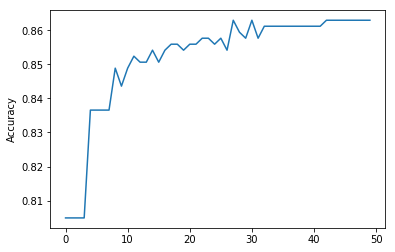

In [17]:
result = np.zeros(N, dtype=np.float64)
weighted_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)

accuracy = np.zeros(no_of_iterations) #accuracy after adding each classifier i.e. at each iteration

#combining the weak classifiers to get a final label output for the final result

best_accuracy = 0
best_iter = 0

for iteration in range(no_of_iterations):  
    
    temp = h[iteration][2] * np.sign(data[:, int(h[iteration][1])] - h[iteration][0])
    weighted_sum = np.float64(weighted_sum + alpha[iteration] * temp)
    result = np.sign(weighted_sum)
    
    accuracy[iteration] = np.sum(np.float64(result == labels)) / N #correct predictions / total predictions
    
    if accuracy[iteration] > best_accuracy: 
        best_accuracy = accuracy[iteration]
        best_iter = iteration

print("Accuracy results: ")
print("No of iterations: ", no_of_iterations)
print("Final accuracy after all iterations: ", accuracy[no_of_iterations-1])
print("Best accuracy is "+str(best_accuracy)+" at the "+str(best_iter)+" iteration.")

# Plot the accuracy
plt.figure()
plt.plot(accuracy)
plt.ylabel('Accuracy')

### AdaBoost in Practice

While the code sample helps us understand how Adaboost works and provides valuable insight, in practice you would simply use the sklearn module to classify your dataset. A small example of using AdaBoost is shown below.

Accuracy results: 
No of iterations:  50
Final accuracy after all iterations:  0.9707602339181286
Best accuracy is 0.9766081871345029 at the 25 iteration.


Text(0,0.5,'Accuracy')

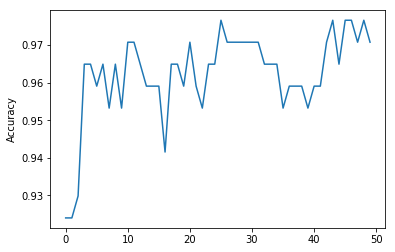

In [26]:
#Load the data from scikit
dataset = load_breast_cancer()
data = dataset.data
labels = dataset.target

#split the data into test and train subsets

no_of_iterations = 50

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=23) # we fix the random state to ensure the same split everytime

accuracies = []

for iteration in range(1, no_of_iterations+1):

    clf = AdaBoostClassifier(random_state=42, n_estimators=iteration)

    # Fit the classifier on the data
    clf.fit(x_train, y_train)

    # make predictions for test subset
    y_pred = clf.predict(x_test)

    # calculate the accuracy of the classifier
    accuracy = (accuracy_score(y_pred, y_test))
    accuracies.append(accuracy)
    
best_accuracy = max(accuracies)
best_iter = accuracies.index(best_accuracy)

print("Accuracy results: ")
print("No of iterations: ", no_of_iterations)
print("Final accuracy after all iterations: ", accuracies[-1])
print("Best accuracy is "+str(best_accuracy)+" at the "+str(best_iter)+" iteration.")


plt.figure()
plt.plot(accuracies)
plt.ylabel('Accuracy')

### Multi Class AdaBoost

The natural extension to Adaboost capable of "boosting" a binary classification is multi-class Adaboost. While multi-class version of Adaboost has been proposed several times, the most commonly used technique was introduced in 2009 by Zhu et al [7]. This technique is called SAMME - Stagewise Additive Modeling using a Multi-class Exponential loss function. 

It is very similar to how Adaboost works, except that we change how alpha is updated. 

In Adaboost, we learnt that: <b>alpha_t = log( (1/err_t) - 1)</b>
For multi-class Adaboost: <b>alpha_t = log( (1/err_t) - 1) + log(no_of_classes -1)</b> 

Using our updated value of alpha, if no_of_classes = 2, log(no_of_classes - 1) becomes log(1) which is 0, thus giving us our original equation back.

to-do-exercise-2: How will we update the error condition to ensure that our chosen error rate at any given iteration is lower than random guessing?

In fact, the sklearn Adaboost classifier is capable of handling multiple classes. We will look at an example of how to use sklearn adaboost for multiple classes. We will use one of the sklearn's pre-available datasets. At the beginning of the tutorial we discussed that Adaboost is also useful to build on top of other techniques. We will also try to see a comparison between using the default Adaboost versus an Adaboosted decision tree classifier in this example. 

In [266]:
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier

dataset = load_wine() 
data = dataset.data
labels = dataset.target #This dataset contains 3 classes.

#split the data into test and train subsets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42) # we fix the random state to ensure the same result every time

clf_ada = AdaBoostClassifier(random_state=42)

clf_ada_dtc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    random_state=42)

# Fit the classifier on the data
clf_ada.fit(x_train, y_train)
clf_ada_dtc.fit(x_train, y_train)

# make predictions for test subset
y_pred_ada = clf_ada.predict(x_test)
y_pred_ada_dtc = clf_ada_dtc.predict(x_test)

# calculate the accuracy of the classifier
print("accuracy by only adaboost: ", accuracy_score(y_pred_ada, y_test))
print("accuracy by adaboosted decision trees: ", accuracy_score(y_pred_ada_dtc, y_test))

accuracy by only adaboost:  0.9259259259259259
accuracy by adaboosted decision trees:  0.9444444444444444


While in our example the adaboosted decision trees perform better than using the generic adaboost weak classifiers, it may not always be the case. While an ensemble technique like adaboost is a great way to "boost" your accuracy, it may not always work. You should always determine if this is the right approach for your problem. We have listed some of the pros/cons of this approach here. 

#### Pros
1. It aids in feature selection that can result in both accuracy and time boost when working with large datasets. 
2. It isn't prone to overfitting. 
3. It can be used in conjunction with many different classifiers, an example of which is shown above in this tutorial. 

#### Cons
1. It may converge at a suboptimal solution. 
2. It is very sensitive to noise and outliers. If your data contains some outliers, Adaboost may not be right approach for you. 


### Solutions to to-do exercises:
#### To-do exercise 1:

In [230]:
### ONLY SOLUTION SNIPPET - NOT RUNNABLE CODE
for iteration in range(no_of_iterations):
    for thresh in threshold:
        for dimension in range(dim):
            for sign in [-1, 1]:
                clf_error, temp_out = generic_clf_error(data, labels, weight, dimension, thresh, sign)
                if(clf_error < errors[iteration]):  #the best classifier in this iteration gets stored in hypothesis (h)
                    out = temp_out
                    errors[iteration] = clf_error
                    h[iteration] = [thresh,dimension,sign]
   
    # At the end of every iteration, we are ensuring that the best (miminal) error we could find was less than 1/2
    if(errors[iteration] > 0.5):
        print("We don't have a sufficiently good enough pool of classifiers to choose from!")
        print("error occured at iteration: ", iteration)
        break

#### To-do exercise 2:

Our error condition will change to: error < ( 1 - (1/no_of_classes) )

## Additional Resources:

1. Full mathematical explanation behind AdaBoost: http://rob.schapire.net/papers/explaining-adaboost.pdf
2. Slides with animation and mathametical proof of how AdaBoost works: https://www.csie.ntu.edu.tw/~mhyang/course/u0030/papers/schapire.pdf
3. General overview similar to this tutorial: https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/

You may also refer to any of the reference sources that I refered to while making this tutorial.

#### References:

1. https://github.com/jaimeps/adaboost-implementation
2. http://www.ritchieng.com/machine-learning-ensemble-of-learners-adaboost/ 
3. https://github.com/riddhishb/ipython-notebooks/tree/master/Adaboost
4. http://scikit-learn.org/stable/modules/ensemble.html#adaboost
5. https://medium.com/machine-learning-101/https-medium-com-savanpatel-chapter-6-adaboost-classifier-b945f330af06
6. http://mccormickml.com/2013/12/13/adaboost-tutorial/
7. Hastie, Trevor, et al. "Multi-class adaboost." Statistics and its Interface 2.3 (2009): 349-360.